# YOURCABS Cancellation problem.

- Team Members:
 - Aditya
 - Ajinkya
 - Nikita
 - Vidhya

**The problem of interest is booking cancellations by the company due to unavailability of a car.**



In [1]:
#Essential imports
#Pandas library helps to perform various functions on dataframe.
import pandas as pd
#Imported to handle dates and time.
import datetime
#Numpy Provides a fast numerical array structure and helper functions.
import numpy as np
#Will be used for Sampling the dataset.
from sklearn.cross_validation import StratifiedShuffleSplit
#Libraries used for graphs and plots
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
#Imports to implement various Algorithms.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

#Classifier evaluation tools

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools

# Step 1: Data Pre - Processing.

In [2]:
#Read the CSV datafile
data = pd.read_csv('Kaggle_YourCabs_training.csv')

In [3]:
data.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0


**Data fields**

- id - booking ID
- user_id - the ID of the customer (based on mobile number)
- vehicle_model_id - vehicle model type.
- package_id - type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs & 30kms, 7=12hrs & 120kms)
- travel_type_id - type of travel (1=long distance, 2= point to point, 3= hourly rental).
- from_area_id - unique identifier of area. Applicable only for point-to-point travel and packages
- to_area_id - unique identifier of area. Applicable only for point-to-point travel
- from_city_id - unique identifier of city
- to_city_id - unique identifier of city (only for intercity)
- from_date - time stamp of requested trip start
- to_date - time stamp of trip end
- online_booking - if booking was done on desktop website
- mobile_site_booking - if booking was done on mobile website
- booking_created - time stamp of booking
- from_lat - latitude of from area
- from_long -  longitude of from area
- to_lat - latitude of to area
- to_long - longitude of to area
- Car_Cancellation (available only in training data) - whether the booking was cancelled (1) or not (0) due to unavailability of a car.
- Cost_of_error (available only in training data) - the cost incurred if the booking is misclassified. For an un-cancelled booking, the cost of misclassificaiton is 1. For a cancelled booking, the cost is a function of the cancellation time relative to the trip start time (see Evaluation Page).

In [4]:
#Generate new columns based on existing data to get better insights.
data['Binned_pickup_month'] = pd.DatetimeIndex(data['from_date']).month

data['Pickup_Day_of_Week'] = pd.DatetimeIndex(data['from_date']).weekday
data['Pickup_Day_of_Week']=data['Pickup_Day_of_Week']+1

data['Booking_day_of_the_Week'] = pd.DatetimeIndex(data['booking_created']).weekday
data['Booking_day_of_the_Week'] = data['Booking_day_of_the_Week'].astype(int)
data['Booking_day_of_the_Week']=data['Booking_day_of_the_Week']+1

data['Binned_booking_month'] = pd.DatetimeIndex(data['booking_created']).month

In [5]:
data.from_date = pd.to_datetime(data['from_date'])
data['pick_up_time_of_day']=pd.DatetimeIndex(data['from_date']).hour

def pickup_printime(houroftheday):
    if (houroftheday<4):
        interval=1
        return interval
    elif (houroftheday<8):
        interval=2
        return interval
    elif (houroftheday<12):
        interval=3
        return interval
    elif (houroftheday<16):
        interval=4
        return interval
    
    elif (houroftheday<20):
        interval=5
        return interval
    elif  houroftheday<=24:        
        interval=6
    return interval
data['Binned_pickup_time_of_day']=list(map(pickup_printime,data['pick_up_time_of_day']))

data['booking_time_of_day']=pd.DatetimeIndex(data['booking_created']).hour

data['Binned_booking_time_of_day']=list(map(pickup_printime,data['booking_time_of_day']))

data = data.drop('booking_time_of_day',1)

data = data.drop('pick_up_time_of_day',1)

In [6]:
#Finding if booking within a day
data['sub_month']=data['Binned_pickup_month']-data['Binned_booking_month']
data['sub_day']=data['Pickup_Day_of_Week']-data['Booking_day_of_the_Week']
data['Booking_Within_a_Day']=data['sub_month']+data['sub_day']
#normalising
def normalization(day):
    if(day == 0):
        return 0
    else:
        return 1
data['Is_Booking_Within_a_Day'] = list(map(normalization,data['Booking_Within_a_Day']))
data = data.drop('sub_month',1)
data = data.drop('sub_day',1)
data = data.drop('Booking_Within_a_Day',1)

In [7]:
data.columns.itemsize
data = data.drop('id',1)
data = data.drop('user_id',1)
data = data.drop('vehicle_model_id',1)
data = data.drop('package_id',1)
data = data.drop('travel_type_id',1)
data = data.drop('from_area_id',1)
data = data.drop('to_area_id',1)
data = data.drop('from_city_id',1)
data = data.drop('to_city_id',1)
data = data.drop('from_date',1)
data = data.drop('from_lat',1)
data = data.drop('from_long',1)
data = data.drop('Cost_of_error',1)
data = data.drop('to_date',1)
data = data.drop('to_lat',1)
data = data.drop('to_long',1)
data = data.drop('booking_created',1)

data.columns

Index(['online_booking', 'mobile_site_booking', 'Car_Cancellation',
       'Binned_pickup_month', 'Pickup_Day_of_Week', 'Booking_day_of_the_Week',
       'Binned_booking_month', 'Binned_pickup_time_of_day',
       'Binned_booking_time_of_day', 'Is_Booking_Within_a_Day'],
      dtype='object')

**New Data fields:**
- Booking_Day_Of_The_Week - value = 1-7 for Sunday to Saturday
- Pickup_Day_Of_The_Week - value = 1-7 for Sunday to Saturday
- Binned_Booking_Time_Of_The_Day - value = 1(12am – 4am) and so on upto value = 6(8pm – 12am)
- Binned_Pickup_Time_Of_Day - value = 1(12am – 4am) and so on upto value = 6(8pm – 12am)
- Binned_Pickup_Month - value = 1 to 12 for January to December.
- Binned_Booking_Month - value = 1 to 12 for January to December.
- Is_Booking_Within_a_day - value	=	0	if	the	cab	booking	was done	within	24	hrs;value	=	1	if	the	cab	booking	was	done	before	1	day	upto	a	month.
- online_booking - Value	=	1	if	booking	was	done	on	desktop	website.
- mobile_site_booking - Value	=	1	if	booking	was	done	on	mobile	website

# Step 2 : Feature Extraction

In [8]:
#Feature selection
features = data[['online_booking', 'mobile_site_booking',
       'Binned_pickup_month', 'Pickup_Day_of_Week', 'Booking_day_of_the_Week',
       'Binned_booking_month', 'Is_Booking_Within_a_Day',
       'Binned_pickup_time_of_day', 'Binned_booking_time_of_day']]

In [9]:
#Class label
y = data.Car_Cancellation
#Sampling - Stratfied: Test 30% & Train = 70%
sss = StratifiedShuffleSplit(y, n_iter=2, test_size=0.3)

In [10]:
train_index, test_index = next(iter(sss))
X_train = features.iloc[train_index]
y_train = y.iloc[train_index]
X_test = features.iloc[test_index]
y_test = y.iloc[test_index]

In [11]:
X_train.shape, X_test.shape

((30401, 9), (13030, 9))

In [12]:
## Take a sample from the training data to do feature selection
sss = StratifiedShuffleSplit(y_train, n_iter=2, test_size=0.2)

In [13]:
#Generate indices
train_index, test_index = next(iter(sss))
#20% data is used for feature extraction
X_train_features = X_train.iloc[test_index]
y_train_features = y_train.iloc[test_index]

#80% data is remaining
X_train_rest = X_train.iloc[train_index]
y_train_rest = y_train.iloc[train_index]
print(len(X_train_features))
print(len(y_train_features))

6081
6081


In [14]:
X_train_features.shape, X_train_rest.shape

((6081, 9), (24320, 9))

In [57]:
#Instantiate Support vector classifier
svc = svm.SVC(kernel='linear', C=1)
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y_train_features, 5), scoring='roc_auc')
#Fitting regression model
rfecv.fit(X_train_features, y_train_features)

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=5, shuffle=False, random_state=None),
   estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   estimator_params=None, scoring='roc_auc', step=1, verbose=0)

In [35]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 7


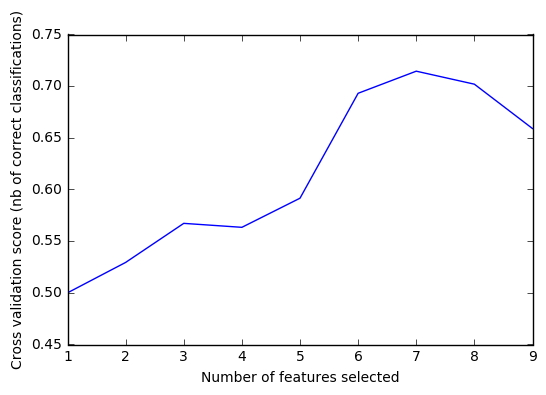

In [36]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [37]:
#Diplaying features which support desired class label.
rfecv.support_

array([ True,  True,  True, False,  True, False,  True,  True,  True], dtype=bool)

In [38]:
import numpy as np
features_cols_np = np.array(features.columns)

In [39]:
#Extracting features
features_to_consider = features_cols_np[rfecv.support_]

In [40]:
print ('Selected features are %s ' %(features_to_consider))

Selected features are ['online_booking' 'mobile_site_booking' 'Binned_pickup_month'
 'Booking_day_of_the_Week' 'Is_Booking_Within_a_Day'
 'Binned_pickup_time_of_day' 'Binned_booking_time_of_day'] 


In [41]:
#Diplaying eliminated feature
features_eliminated = features_cols_np[rfecv.support_ == False]

In [42]:
features_eliminated

array(['Pickup_Day_of_Week', 'Binned_booking_month'], dtype=object)

# Step 3:  Model Training

We have used KNN & SVM algorithm to train our predictive classification model.

In [43]:
Xt = X_train_rest[features_to_consider]
yt = y_train_rest
print(len(Xt))
print(len(yt))

24320
24320


In [44]:
Xtr, Xv, ytr, yv = train_test_split(Xt, yt, test_size=0.3)

In [45]:
#Create an array to store results of varios neighbors in KNN.
results = []


for n in range(1, 51, 2):
    
    knn = KNeighborsClassifier(weights='distance', n_neighbors=n)
    #Train the model on the training data set.
    knn.fit(Xt, yt)
    #Predict class labels using our trained model to evaluate the perfomance.
    p = knn.predict(Xv)
    accuracy = metrics.accuracy_score(yv,p)
    results.append([n, accuracy])

In [46]:
#Store the results into a dataframe
results = pd.DataFrame(results, columns=["n","accuracy"])
knn_accuracy = max(results.accuracy)

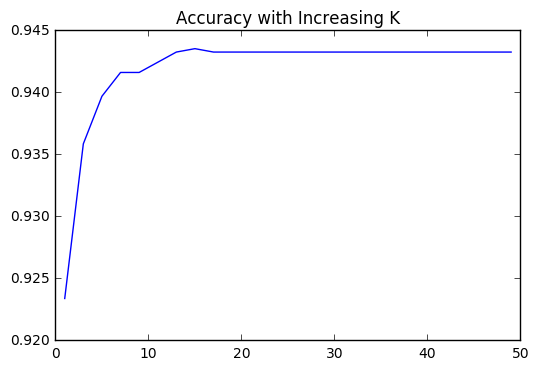

In [47]:
pl.plot(results.n,results.accuracy)
pl.title("Accuracy with Increasing K")
pl.show()

We can see from the plot that is the number of neighbors increase the accuracy increases initially. However, after a certain number of neighbors is reached the accuracy starts dropping. This is due to model overfitting.

In [48]:
#Training KNN model for ideal value of Neighbors 'n'.
ideal_n = results.loc[results['accuracy'].idxmax()].n
print('Ideal value of neighbors would be', ideal_n)
knn = KNeighborsClassifier(weights='distance', n_neighbors=ideal_n)
knn.fit(Xt, yt)
ytest_pred_knn = knn.predict_proba(Xv)[:, 1]
ytest_preds_threshold = [1 if pred > 0.10 else 0 for pred in ytest_pred_knn]
knn_auc_roc = roc_auc_score(yv, ytest_preds_threshold)

Ideal value of neighbors would be 15.0


C:\Users\Ajinkya\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


In [58]:
#Train the model
SVC=svc.fit(Xt, yt)

In [59]:
svm_p = svc.predict(Xv)
svm_accuracy = metrics.accuracy_score(yv,svm_p)
svm_auc_roc = roc_auc_score(yv, svm_p)

# Step 4: Model Evaluation

In [51]:
print ('ROC AUC score for KNN on the test dataset ', knn_auc_roc)

ROC AUC score for KNN on the test dataset  0.901671498207


In [52]:
print ('ROC AUC score of SVM on the test dataset ', svm_auc_roc)

ROC AUC score of SVM on the test dataset  0.5


In [53]:
print('Accuracy of KNN model', knn_accuracy)

Accuracy of KNN model 0.943530701754


In [54]:
print('Accuracy of SVM model', svm_accuracy)

Accuracy of SVM model 0.925712719298


Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.06  0.94]]


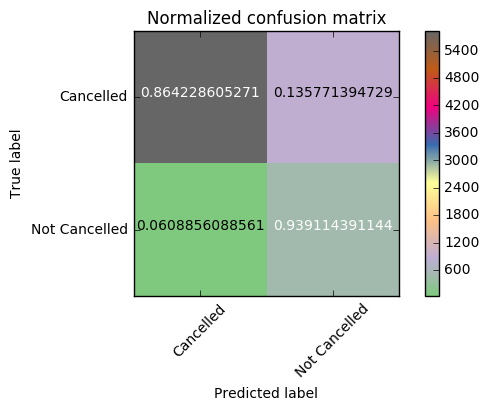

In [62]:
#Define a function to calculate and plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Accent):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(yv, ytest_preds_threshold)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=['Cancelled','Not Cancelled'],
#                      title='Confusion matrix, without normalization')



# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Cancelled','Not Cancelled'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()